n=2, p1=0.0266, p2=0.0815, d=0.85, fidelity=0.9748
n=3, p1=0.0290, p2=0.1934, d=0.85, fidelity=0.9274
n=4, p1=0.0366, p2=0.1616, d=0.85, fidelity=0.9200
n=5, p1=0.0463, p2=0.2041, d=0.85, fidelity=0.8940
n=6, p1=0.0310, p2=0.1599, d=0.85, fidelity=0.8989


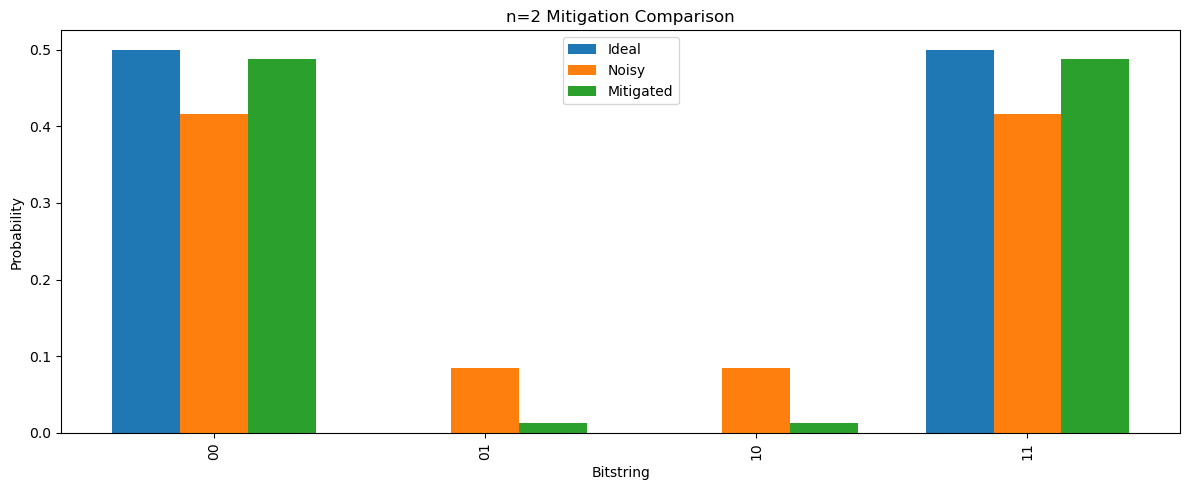

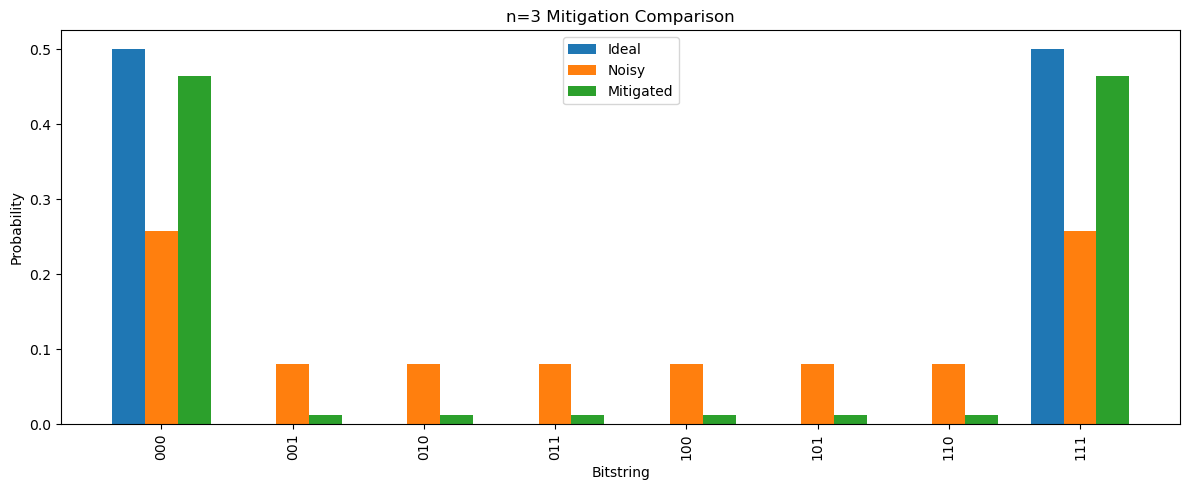

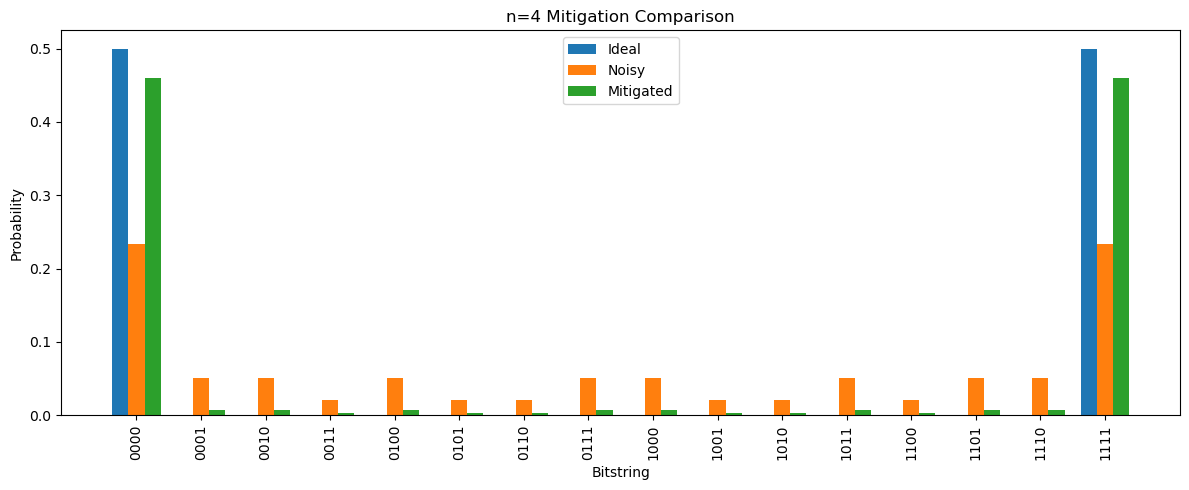

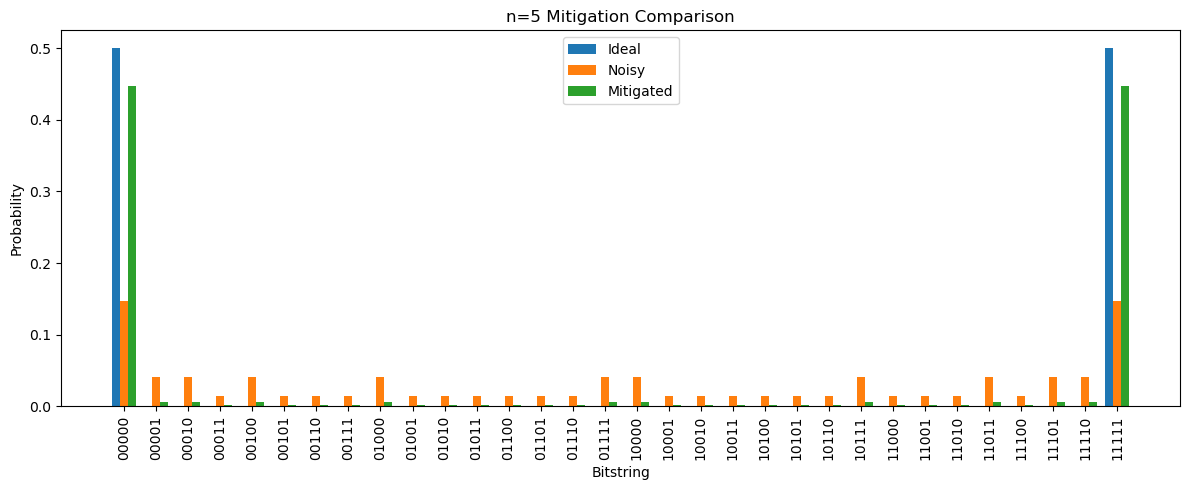

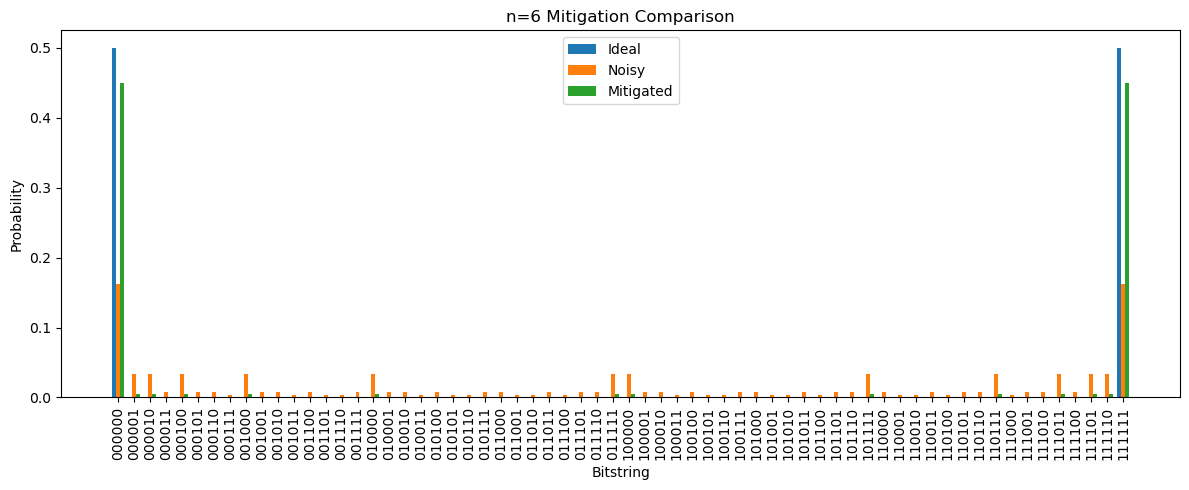

In [1]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import pinv
from scipy.optimize import fsolve
from sklearn.linear_model import Ridge

def kronecker_n(mat, n):
    result = 1
    for _ in range(n):
        result = np.kron(result, mat)
    return result

def construct_M_spam(p2, n):
    p2 = np.clip(p2, 0, 0.3)
    M_single = np.array([[1 - p2, p2], [p2, 1 - p2]])
    return kronecker_n(M_single, n)

def construct_M_depol(p1, n):
    p1 = np.clip(p1, 0, 0.3)
    M_single = np.array([[1 - p1/2, p1/2], [p1/2, 1 - p1/2]])
    return kronecker_n(M_single, n)

def construct_mitigation_operator(M_spam, M_depol):
    return pinv(M_spam) @ pinv(M_depol)

def apply_damping(M_mit, d):
    I = np.eye(M_mit.shape[0])
    return I + d * (M_mit - I)

def estimate_noise_params(S_zero, S_cat, n):
    def eq_p2(p2):
        return S_zero - n * (p2 * np.log2(1/p2 + 1e-10) + p2 / np.log(2))
    def eq_p1(p1):
        return S_cat - S_zero - 1 - n * (p1 * np.log2(1/p1 + 1e-10) + p1 / np.log(2))
    p2 = float(fsolve(eq_p2, 0.05)[0])
    p1 = float(fsolve(eq_p1, 0.05)[0])
    return max(min(p1, 0.3), 0.001), max(min(p2, 0.3), 0.001)

def grid_search_damping(M_mit, P_noisy, P_ideal):
    best_d, best_fid = 0, 0
    for d in np.linspace(0.01, 0.85, 50):
        M_damp = apply_damping(M_mit, d)
        P_mit = M_damp @ P_noisy
        P_mit = np.maximum(P_mit, 0)
        P_mit /= np.sum(P_mit)
        fid = np.sum(np.sqrt(P_mit) * np.sqrt(P_ideal))**2
        if fid > best_fid:
            best_fid = fid
            best_d = d
    return best_d, best_fid

def generate_entropy(p1, p2, n, noise="cat"):
    if noise == "zero":
        return n * (p2 * np.log2(1/p2 + 1e-10) + p2 / np.log(2))
    elif noise == "cat":
        S0 = n * (p2 * np.log2(1/p2 + 1e-10) + p2 / np.log(2))
        S1 = n * (p1 * np.log2(1/p1 + 1e-10) + p1 / np.log(2))
        return 1 + S0 + S1
    return 0

def simulate(n, p1_true, p2_true):
    S_zero = generate_entropy(p1_true, p2_true, n, "zero")
    S_cat = generate_entropy(p1_true, p2_true, n, "cat")
    p1, p2 = estimate_noise_params(S_zero, S_cat, n)

    M_spam = construct_M_spam(p2, n)
    M_depol = construct_M_depol(p1, n)
    M_mit = construct_mitigation_operator(M_spam, M_depol)

    P_ideal = np.zeros(2**n)
    P_ideal[0] = P_ideal[-1] = 0.5
    P_noisy = M_spam @ M_depol @ P_ideal
    P_noisy = np.maximum(P_noisy, 0)
    P_noisy /= np.sum(P_noisy)

    d, fid = grid_search_damping(M_mit, P_noisy, P_ideal)
    P_mitigated = apply_damping(M_mit, d) @ P_noisy
    P_mitigated = np.maximum(P_mitigated, 0)
    P_mitigated /= np.sum(P_mitigated)
    return p1, p2, d, fid, P_noisy, P_mitigated, P_ideal

def run_scaling_study():
    results = []
    for n in range(2, 7):
        p1_true = np.random.uniform(0.02, 0.08)
        p2_true = np.random.uniform(0.05, 0.25)
        p1, p2, d, fid, P_noisy, P_mitigated, P_ideal = simulate(n, p1_true, p2_true)
        results.append({
            "n": n, "p1": p1, "p2": p2, "d": d, "fidelity": fid,
            "P_noisy": P_noisy, "P_mitigated": P_mitigated, "P_ideal": P_ideal
        })
        print(f"n={n}, p1={p1:.4f}, p2={p2:.4f}, d={d:.2f}, fidelity={fid:.4f}")
    return results

def plot_distributions(P_ideal, P_noisy, P_mitigated, n):
    x = np.arange(len(P_ideal))
    labels = [f"{i:0{n}b}" for i in x]
    width = 0.25
    plt.figure(figsize=(12,5))
    plt.bar(x - width, P_ideal, width, label="Ideal")
    plt.bar(x, P_noisy, width, label="Noisy")
    plt.bar(x + width, P_mitigated, width, label="Mitigated")
    plt.xticks(x, labels, rotation=90)
    plt.xlabel("Bitstring")
    plt.ylabel("Probability")
    plt.title(f"n={n} Mitigation Comparison")
    plt.legend()
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    all_results = run_scaling_study()
    for r in all_results:
        plot_distributions(r["P_ideal"], r["P_noisy"], r["P_mitigated"], r["n"])
